In [1]:
%matplotlib widget
import numpy as np
import json, glob, copy
import os, math
import pandas as pd
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit
from IPython.display import clear_output, display
from datetime import datetime

from alvra_tools.load_data import *
from alvra_tools.channels import *
from alvra_tools.timing_tool import *
from alvra_tools.utils import *
from alvra_tools.YAG_scans import *
from alvra_tools.XAS_functions import *
from ipyfilechooser import FileChooser

import warnings
warnings.filterwarnings('ignore')

## choose run number

In [14]:
pgroup='p21533'
runnumber = 302
print ('run: {:04d}'.format(runnumber))

#############################################################
jsonfile = ''
jsonfile = glob.glob('/sf/alvra/data/{}/raw/*{:04d}*/meta/scan.json'.format(pgroup, runnumber))[0]
titlestring = str( pgroup + ' --- ' +jsonfile.split('/')[-3])
run_name = jsonfile.split('/')[-3]
jsonfile

run: 0302


'/sf/alvra/data/p21533/raw/run0302-t0_SiN_scan_9keV_pink/meta/scan.json'

In [15]:
TT1 = TT_PSEN124
TT2 = TT_PSEN126

quantile_band = 0.5

channel_delay_motor = channel_delay_topas

Timezero_mm = 190.045820 ## Put here the value from the fit without TT (from YAG_scans_noTT.ipynb)
reducedir='../Reduced_data/Reduced_YAG_2TTs/'
saveflag = True

########################################
#YAG_scan_two_TT_bs(scan, TT1, TT2, channel_delay_motor, timezero_mm, quantile, filterTime_1=2000, filterAmp_1=-100, filterTime_2=2000, filterAmp_2=-100):
########################################
flag = True

try:
    Timezero_mm = get_timezero_NBS(jsonfile)
    flag = True
except:
    Timezero_mm = Timezero_mm

from sfdata import SFScanInfo
scan = SFScanInfo(jsonfile)
scan = remove_JF_from_scan(scan)

Delay_rbk, Pump_probe, Delays_fs_scan_124, Delays_corr_scan_124, arrTimes_scan_124, arrTimesAmp_scan_124, Pump_probe_scan_124, \
                       Delays_fs_scan_126, Delays_corr_scan_126, arrTimes_scan_126, arrTimesAmp_scan_126, Pump_probe_scan_126 = \
                       YAG_scan_two_TT_bs(scan, TT1, TT2, channel_delay_motor, Timezero_mm, quantile_band)

if saveflag:
    os.makedirs(reducedir+run_name, exist_ok=True)
    save_run_array_YAG_2TTs(reducedir, run_name, Delay_rbk, 
                            Delays_fs_scan_124, Delays_corr_scan_124, Pump_probe, Pump_probe_scan_124,
                            Delays_fs_scan_126, Delays_corr_scan_126, Pump_probe, Pump_probe_scan_126)

print ('------------------------------')
if flag:
    print ('Timezero found in file = {} mm'.format(Timezero_mm))
else:
    print ('Timezero = {} mm'.format(Timezero_mm))

Processing: run0302-t0_SiN_scan_9keV_pink
Step 41 of 41: Processing acq0041

--------------------------------------------------------------------------------

SAR-CVME-TIFALL4:EvtSet                   501 / 501 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SARES11-SPEC125-M1.edge_amplitude         501 / 501 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SARES11-SPEC125-M1.edge_amplitude2        501 / 501 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SARES11-SPEC125-M1.edge_derivative        501 / 501 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SARES11-SPEC125-M1.edge_derivative2       501 / 501 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SARES11-SPEC125-M1.edge_position          501 / 501 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SARES11-SPEC125-M1.edge_position2         501 / 501 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SARES11-SPEC125-M1.edge_raw               501 / 501 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SARES11-SPEC125-M1.edge_raw2              501 / 501 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SARES11-SPEC125-M1.projection_background  501 / 501 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SARES11-SPEC125-M1.projection_background2 501 / 501 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SARES11-SPEC125-M1.projecti

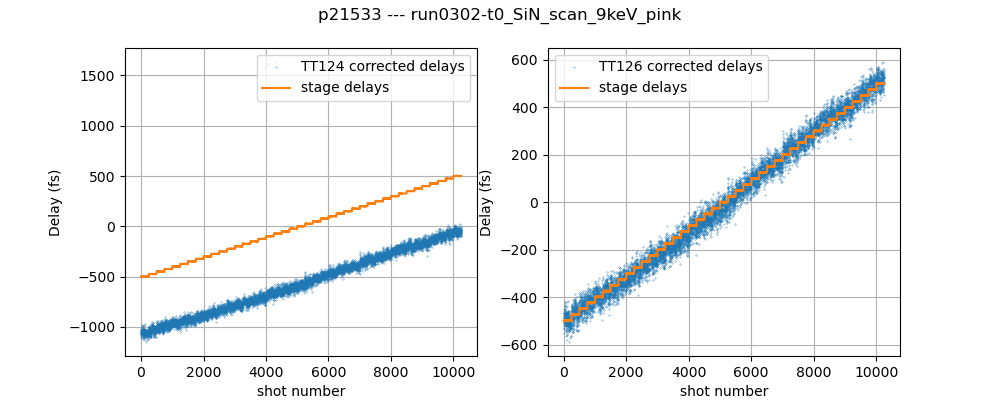

In [22]:
fig, axs = plt.subplots(1,2, figsize=(10,4))
plt.suptitle(titlestring)
ax1 = axs[0]
ax2 = axs[1]

ax1.plot(Delays_corr_scan_124, '.',ms=0.5, label = 'TT124 corrected delays')
ax1.plot(Delays_fs_scan_124, label = 'stage delays')
ax2.plot(Delays_corr_scan_126, '.',ms=0.5, label = 'TT126 corrected delays')
ax2.plot(Delays_fs_scan_126, label = 'stage delays')
ax1.legend (loc='best')
ax2.legend (loc='best')
ax1.grid()
ax2.grid()
ax1.set_xlabel('shot number')
ax1.set_ylabel('Delay (fs)')
ax2.set_xlabel('shot number')
ax2.set_ylabel('Delay (fs)')
plt.show()
plt.tight_layout()

8200
(8200,) shots out of (10250,) survived


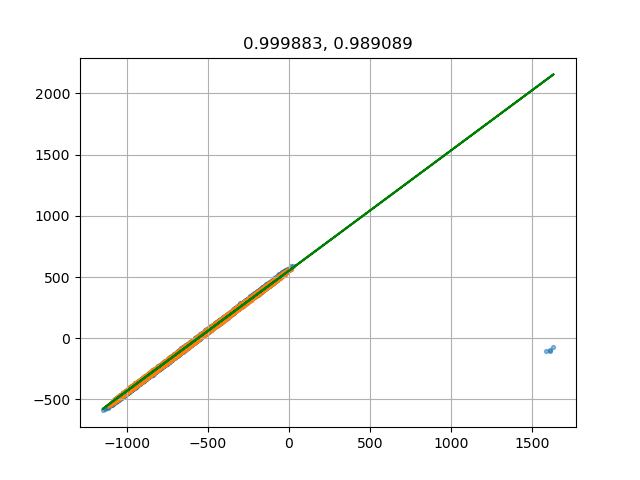

In [23]:
correlation_filter, line = make_correlation_filter2(Delays_corr_scan_124, Delays_corr_scan_126, 0.8)

arrays_to_filter = ["arrTimesAmp_scan_124",
                    "arrTimesAmp_scan_126",
                    "Delays_corr_scan_124",
                    "Delays_corr_scan_126",
                    "Delays_fs_scan_124",
                    "Delays_fs_scan_126",
                    "Pump_probe_scan_124",
                    "Pump_probe_scan_126"
                   ]

arrays_filtered = apply_filter(correlation_filter, arrays_to_filter, globals_dict=globals())
print (len(Delays_corr_scan_124_filter))

plt.figure()
plt.title('{:.6f}, {:.6f}'.format(pearsonr(Delays_corr_scan_124_filter, Delays_corr_scan_126_filter)[0], pearsonr(Delays_corr_scan_124, Delays_corr_scan_126)[0]))

plt.scatter(Delays_corr_scan_124, Delays_corr_scan_126, s=8,alpha = 0.5, label ='unfiltered')
plt.scatter(Delays_corr_scan_124_filter, Delays_corr_scan_126_filter,s=8, alpha = 0.5, label ='filtered')
plt.plot(Delays_corr_scan_124, line, color = 'green')
plt.grid()

print ('{} shots out of {} survived'.format(np.shape(Delays_corr_scan_124_filter), np.shape(Delays_corr_scan_124)))



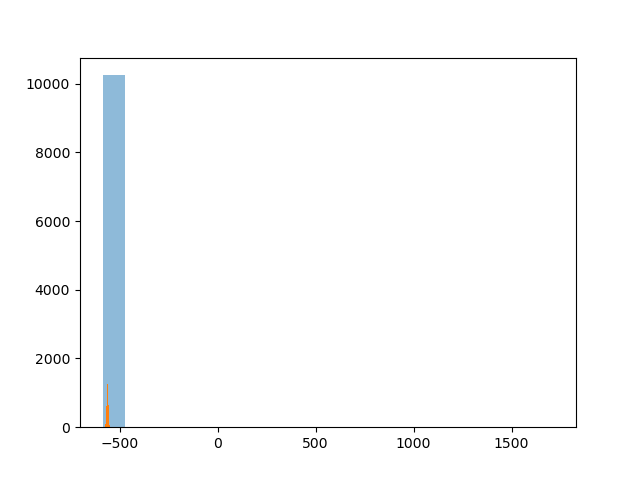

115.18149704958876
11.393542456578857


In [24]:
plt.figure()
plt.hist(Delays_corr_scan_124 - Delays_corr_scan_126, bins = 20, alpha = 0.5)
plt.hist(Delays_corr_scan_124_filter - Delays_corr_scan_126_filter, bins = 20)
plt.show()
print (2.553*np.std(Delays_corr_scan_124 - Delays_corr_scan_126))
print (2.553*np.std(Delays_corr_scan_124_filter - Delays_corr_scan_126_filter))

In [25]:
binsize = 10 # in fs

min_delay = -500
max_delay = 500

#####################################################################################################
from scipy.stats import binned_statistic
print (np.shape(Pump_probe_scan_126),np.shape(Delays_corr_scan_126))
print (np.shape(Pump_probe_scan_126_filter),np.shape(Delays_corr_scan_126_filter))

binList = np.arange(min_delay, max_delay, binsize)
bin_centres = (binList[:-1] + binList[1:])/2

Delay_fs_TT = np.arange(min_delay + binsize/2, max_delay - binsize/2, binsize)

pp_TT, binEdges, binNumber = binned_statistic(Delays_corr_scan_126, Pump_probe_scan_126, statistic=np.nanmean, bins=binList)
pp_TT_filter, binEdges, binNumber = binned_statistic(Delays_corr_scan_126_filter, Pump_probe_scan_126_filter, statistic=np.nanmean, bins=binList)

(10250,) (10250,)
(8200,) (8200,)


In [19]:
# err function ---------------> [x0, amplitude, width, offset]
# exp_gauss_heaviside --------> [x0, amplitude, width, offset, lifetime]
# conv_exp_gauss_heaviside2 --> [x0, amplitude, width, offset, lifetime, a, b]

#fit = Fit(errfunc_fwhm, estimate_errfunc_parameters)
#fit = Fit(conv_exp_gauss_heaviside, estimate_conv_exp_gauss_heaviside_parameters) 
fit = Fit(conv_exp_gauss_heaviside2, estimate_conv_exp_gauss_heaviside2_parameters)

In [20]:
index = ~(np.isnan(Delay_fs_TT) | np.isnan(pp_TT))
Delay_fs_TT = Delay_fs_TT[index]
pp_TT = pp_TT[index]

fit.estimate(Delay_fs_TT, pp_TT)            # this sets some internal params 
#print(fit.p0)
fit.p0 = better_p0(fit.p0, 4,200)# overwrite some values (index) if needed: 
#fit.p0 =[0, 0.04, 50, 0.0, 500, 3e-5, 0.035]
#fit.p0 =[0, 0.04, 50, 0.0, 500]
#print(fit.p0)

fit.fit(Delay_fs_TT,pp_TT, maxfev=200000)                  # calculate the fit (put maxfev=# here if needed)
pp_fit = fit.eval(Delay_fs_TT)           # evaluate the curve for plotting

t0_fs = fit.popt[0]
t0_mm = Timezero_mm + fs2mm(t0_fs, 0)
width_fs = fit.popt[2]

fit.estimate(Delay_fs_TT, pp_TT_filter)            # this sets some internal params 
#print(fit.p0)
fit.p0 = better_p0(fit.p0, 4,200)# overwrite some values (index) if needed: 
#fit.p0 =[0, 0.04, 50, 0.0, 500, 3e-5, 0.035]
#fit.p0 =[0, 0.04, 50, 0.0, 500]
#print(fit.p0)

fit.fit(Delay_fs_TT,pp_TT_filter, maxfev=200000)                  # calculate the fit (put maxfev=# here if needed)
pp_fit_filter = fit.eval(Delay_fs_TT)           # evaluate the curve for plotting

t0_fs_filter = fit.popt[0]
width_fs_filter = fit.popt[2]

print("Width        = {:.4f} fs".format(width_fs))
print("Width filter = {:.4f} fs".format(width_fs_filter))

Width        = 105.3129 fs
Width filter = 103.4205 fs


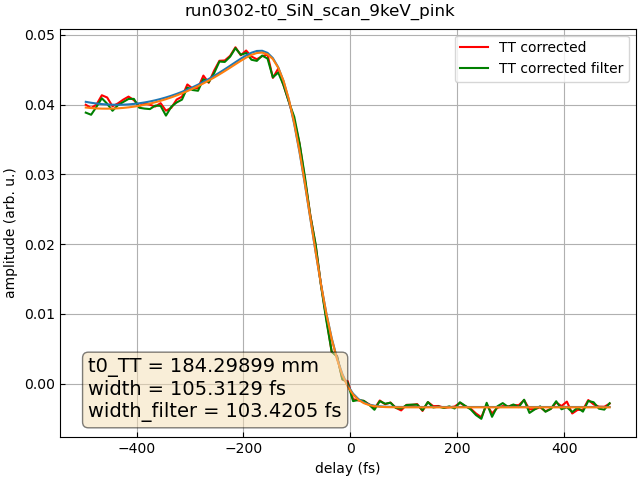

Position t0_raw = 184.31102000004498 mm
Position t0_TT = 184.29899092199597 mm


In [21]:
fig, ax = plt.subplots(constrained_layout=True)
#plt.figure(constrained_layout=True)
plt.suptitle(jsonfile.split('/')[-3] )#+ " mono")

plt.tick_params(direction='in')

#plt.plot(Delays_corr_scan_126, Pump_probe_scan_126, 'o', color='lightblue')#, markersize=0.5)
# plt.plot(Delay_fs, pp_uncorrected, marker='.',label = 'raw scan, t0 = {} mm'.format(timezero_mm))
plt.plot(Delay_fs_TT, pp_TT, color='red', label = 'TT corrected')
plt.plot(Delay_fs_TT, pp_TT_filter, color='green', label = 'TT corrected filter')
plt.plot(Delay_fs_TT, pp_fit)
plt.plot(Delay_fs_TT, pp_fit_filter)

boxstyle = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
boxtext = '\n'.join((#r'Delta_t0 = {} fs'.format(np.round(t0_fs, 5)),
                     r't0_TT = {} mm'.format(np.round(Timezero_mm + fs2mm(t0_fs,0),5)),
            r'width = {:.4f} fs'.format(width_fs), r'width_filter = {:.4f} fs'.format(width_fs_filter)))
plt.text(0.05, 0.05, boxtext, transform=ax.transAxes, bbox=boxstyle, fontsize=14)

plt.xlabel('delay (fs)')
plt.ylabel('amplitude (arb. u.)')
plt.legend (loc = 'upper right')
#plt.ylim(-0.05, 0.2)
plt.grid()
plt.show()

print("Position t0_raw = {} mm".format(Timezero_mm ))
print("Position t0_TT = {} mm".format(Timezero_mm + fs2mm(t0_fs,0)))

In [13]:
pgroup = 'p21533'
Loaddir_name = 'Reduced_YAG_2TTs'

runlist=np.arange(65, 108)

##############################################
Loaddir = '/sf/alvra/data/{}/work/Claudio/{}/'.format(pgroup, Loaddir_name)
#firstrun = glob.glob('/sf/alvra/data/{}/raw/*{:04d}*/meta/scan.json'.format(pgroup, runlist[0]))[0]
#scan = SFScanInfo(firstrun)
titlestring_stack = pgroup + ' --- ' +str(runlist)
datafiles = []
for runnumber in runlist:
    jsonfile = ''
    jsonfile = glob.glob('/sf/alvra/data/{}/raw/*{:04d}*/meta/scan.json'.format(pgroup, runnumber))[0]
    datafiles.append(jsonfile)
datafiles = sorted(datafiles, key = os.path.getmtime)
print (len(datafiles),'files')
#datafiles

43 files


In [ ]:
TT1 = TT_PSEN124
TT2 = TT_PSEN126

quantile_band = 0.5

channel_delay_motor = channel_delay_topas

Timezero_mm = 190.045820 ## Put here the value from the fit without TT (from YAG_scans_noTT.ipynb)
reducedir='../Claudio/Reduced_YAG_2TTs/'
saveflag = True

########################################
#YAG_scan_two_TT_bs(scan, TT1, TT2, channel_delay_motor, timezero_mm, quantile, filterTime_1=2000, filterAmp_1=-100, filterTime_2=2000, filterAmp_2=-100):
########################################
flag = True
from sfdata import SFScanInfo


for num, json_file in enumerate(datafiles):
    print (json_file)
    scan = SFScanInfo(json_file)
    scan = remove_JF_from_scan(scan)
    run_name = json_file.split('/')[-3]
    
    try:
        Timezero_mm = get_timezero_NBS(json_file)
        flag = True
    except:
        Timezero_mm = Timezero_mm

    Delay_rbk, Pump_probe, Delays_fs_scan_124, Delays_corr_scan_124, arrTimes_scan_124, arrTimesAmp_scan_124, Pump_probe_scan_124, \
                           Delays_fs_scan_126, Delays_corr_scan_126, arrTimes_scan_126, arrTimesAmp_scan_126, Pump_probe_scan_126 = \
                           YAG_scan_two_TT_bs(scan, TT1, TT2, channel_delay_motor, Timezero_mm, quantile_band)

    if saveflag:
        os.makedirs(reducedir+run_name, exist_ok=True)
        save_run_array_YAG_2TTs(reducedir, run_name, Delay_rbk, 
                                Delays_fs_scan_124, Delays_corr_scan_124, Pump_probe, Pump_probe_scan_124,
                                Delays_fs_scan_126, Delays_corr_scan_126, Pump_probe, Pump_probe_scan_126)

print ('------------------------------')
if flag:
    print ('Timezero found in file = {} mm'.format(Timezero_mm))
else:
    print ('Timezero = {} mm'.format(Timezero_mm))

Processing: run0069-Water_IRF_2TT_loop_005
Step 10 of 111: Processing acq0010

--------------------------------------------------------------------------------

SAR-CVME-TIFALL4:EvtSet                   501 / 501 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SARES11-SPEC125-M1.edge_amplitude         501 / 501 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SARES11-SPEC125-M1.edge_amplitude2        501 / 501 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SARES11-SPEC125-M1.edge_derivative        501 / 501 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SARES11-SPEC125-M1.edge_derivative2       501 / 501 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SARES11-SPEC125-M1.edge_position          501 / 501 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SARES11-SPEC125-M1.edge_position2         501 / 501 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SARES11-SPEC125-M1.edge_raw               501 / 501 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SARES11-SPEC125-M1.edge_raw2              501 / 501 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SARES11-SPEC125-M1.projection_background  501 / 501 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SARES11-SPEC125-M1.projection_background2 501 / 501 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SARES11-SPEC125-M1.projec

NameError: name 'arrTimesAmp_scan_126_126x' is not defined

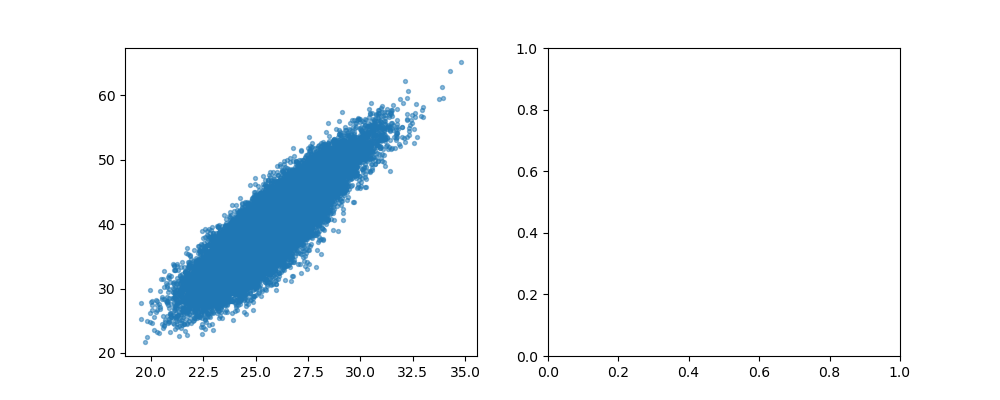

In [33]:
fig, axs = plt.subplots(1,2, figsize=(10,4))
ax1 = axs[0]
ax2 = axs[1]

ax1.scatter(arrTimesAmp_scan_126, arrTimesAmp_scan_124, s=8,alpha = 0.5, label ='unfiltered')
ax1.scatter(arrTimesAmp_scan_126_126x, arrTimesAmp_scan_124_126x,s=8, alpha = 0.5, label ='filtered')
ax1.plot(arrTimesAmp_scan_126, line)

ax2.scatter(arrTimesAmp_scan_124, arrTimesAmp_scan_126, s=8,alpha = 0.5, label ='unfiltered')
ax2.scatter(arrTimesAmp_scan_124_124x, arrTimesAmp_scan_126_124x,s=8, alpha = 0.5, label ='filtered')
ax2.plot(arrTimesAmp_scan_124, line2)

print ('{} shots out of {} survived'.format(np.shape(arrTimesAmp_scan_124_filter), np.shape(arrTimesAmp_scan_124)))

ax1.set_title('{:.4f}, {:.4f}'.format(pearsonr(arrTimesAmp_scan_124_126x, arrTimesAmp_scan_126_126x)[0], pearsonr(arrTimesAmp_scan_124, arrTimesAmp_scan_126)[0]))
ax2.set_title('{:.4f}, {:.4f}'.format(pearsonr(arrTimesAmp_scan_126_124x, arrTimesAmp_scan_124_124x)[0], pearsonr(arrTimesAmp_scan_126, arrTimesAmp_scan_124)[0]))

ax1.grid()
ax2.grid()
plt.show()

In [3]:
TT_PSEN126 = [channel_PSEN126_signal, channel_PSEN126_bkg, channel_PSEN126_arrTimes, channel_PSEN126_arrTimesAmp, channel_PSEN126_peaks, channel_PSEN126_edges]
TT_PSEN124 = [channel_PSEN124_signal, channel_PSEN124_bkg, channel_PSEN124_arrTimes, channel_PSEN124_arrTimesAmp, channel_PSEN124_peaks, channel_PSEN124_edges]

quantile = 0.8

filterTime_126 = 2000
filterAmp_126 = -1000

filterTime_124 = 2000
filterAmp_124 = -1000

channel_delay_motor = channel_delay_topas

channel_list_pp = [channel_Events, channel_LaserDiode, channel_Laser_refDiode, channel_delay_motor, channel_Izero122]  + TT_PSEN126 + TT_PSEN124
channel_list_all = channel_list_pp

Timezero_mm = 190.045820 ## Put here the value from the fit without TT (from YAG_scans_noTT.ipynb)
reducedir='../Claudio/Reduced_YAG_2TT/'
saveflag = False

###########################################################################

flag = False
try:
    Timezero_mm = get_timezero_NBS(jsonfile)
    flag = True
except:
    Timezero_mm = Timezero_mm

from sfdata import SFScanInfo
scan = SFScanInfo(jsonfile)
scan = remove_JF_from_scan(scan)

if ' as delay' in scan.parameters['name'][0]:
    print ('Scan is done with the stage in fs')
    Delay_fs = scan.readbacks
    Delay_mm = fs2mm(scan.readbacks,0)
else:
    print ('Scan is done with the stage in mm')
    Delay_fs = mm2fs(scan.readbacks,0)
    Delay_mm = scan.readbacks

Delay_fs_stage = []
Pump_probe = []
Laser_on = []
Laser_off = []

Izero_pump =[]
Izero_unpump =[]

Pump_probe_scan_126 = []
arrTimes_scan_126 = []
arrTimesAmp_scan_126 = []
Delays_fs_scan_126 = [] 

Pump_probe_scan_124 = []
arrTimes_scan_124 = []
arrTimesAmp_scan_124 = []
Delays_fs_scan_124 = []  

for i, step in enumerate(scan):
    check_files_and_data(step)
    check = get_filesize_diff(step)
    if check:
        clear_output(wait=True)
        filename = scan.files[i][0].split('/')[-1].split('.')[0]
        print ('Processing: {}'.format(scan.fname.split('/')[-3]))
        print ('Step {} of {}: Processing {}'.format(i+1, len(scan.files), filename))

        resultsPP, results_FEL, _, _ = load_data_compact_pump_probe(channel_list_pp, channel_list_all, step)
        
        Izero_pump.extend(resultsPP[channel_Izero122].pump)
        Izero_unpump.extend(resultsPP[channel_Izero122].unpump)

        Laser_pump = resultsPP[channel_LaserDiode].pump
        Laser_ref_pump = resultsPP[channel_Laser_refDiode].pump
        Laser_unpump = resultsPP[channel_LaserDiode].unpump
        Laser_ref_unpump = resultsPP[channel_Laser_refDiode].unpump

        delay_shot = resultsPP[channel_delay_motor].pump
        delay_shot_fs = mm2fs(delay_shot, Timezero_mm)
        Delay_fs_stage.append(delay_shot_fs.mean())

        Laser_diff = -np.log10((Laser_pump) / (Laser_unpump))
        
        Laser_on.extend(Laser_pump)
        Laser_off.extend(Laser_unpump)

        arrTimes_126 = resultsPP[channel_PSEN126_arrTimes].pump
        arrTimesAmp_126 = resultsPP[channel_PSEN126_arrTimesAmp].pump
        sigtraces_126 = resultsPP[channel_PSEN126_edges].pump
        peaktraces_126 = resultsPP[channel_PSEN126_peaks].pump
        
        arrTimes_124 = resultsPP[channel_PSEN124_arrTimes].pump
        arrTimesAmp_124 = resultsPP[channel_PSEN124_arrTimesAmp].pump
        sigtraces_124 = resultsPP[channel_PSEN124_edges].pump
        peaktraces_124 = resultsPP[channel_PSEN124_peaks].pump

        index_126 = (np.asarray(arrTimes_126) < filterTime_126) & (np.asarray(arrTimesAmp_126) > filterAmp_126)
        index_124 = (np.asarray(arrTimes_124) < filterTime_124) & (np.asarray(arrTimesAmp_124) > filterAmp_124)
        
        Delays_fs_scan_126.extend(delay_shot_fs[index_126])
        Delays_fs_scan_124.extend(delay_shot_fs[index_124])
        
        arrTimes_scan_126.extend(arrTimes_126[index_126])
        arrTimesAmp_scan_126.extend(arrTimesAmp_126[index_126]) 
        
        arrTimes_scan_124.extend(arrTimes_124[index_124])
        arrTimesAmp_scan_124.extend(arrTimesAmp_124[index_124]) 
        
        Pump_probe_scan_126.extend(Laser_diff[index_126])
        Pump_probe_scan_124.extend(Laser_diff[index_124])
        
        df_pump_probe = pd.DataFrame(Laser_diff)
        Pump_probe.append(np.nanquantile(df_pump_probe, [0.5, 0.5 - quantile/2, 0.5 + quantile/2]))
        
Delays_fs_scan_126 = np.asarray(Delays_fs_scan_126)
Delays_fs_scan_124 = np.asarray(Delays_fs_scan_124)

arrTimes_scan_126 = np.asarray(arrTimes_scan_126)
arrTimes_scan_124 = np.asarray(arrTimes_scan_124)

arrTimesAmp_scan_126 = np.asarray(arrTimesAmp_scan_126)
arrTimesAmp_scan_124 = np.asarray(arrTimesAmp_scan_124)

Pump_probe_scan_126 = np.asarray(Pump_probe_scan_126)
Pump_probe_scan_124 = np.asarray(Pump_probe_scan_124)
Pump_probe = np.asarray(Pump_probe)
Laser_on = np.asarray(Laser_on)
Laser_off = np.asarray(Laser_off)
Izero_pump = np.asarray(Izero_pump)
Izero_unpump = np.asarray(Izero_unpump)

Delays_corr_scan_126 = Delays_fs_scan_126 + arrTimes_scan_126#((p0 - np.array(edgePos))*px2fs)
Delays_corr_scan_124 = Delays_fs_scan_124 + arrTimes_scan_124#((p0 - np.array(edgePos))*px2fs)

print ("Quantile range = {}".format(0.5 - quantile/2), 0.5 + quantile/2)
print ("Loaded {} files, size of the arrays = {}".format(len(scan.files), len(Pump_probe)))
print ('------------------------------')
print ('Processed {} out of {} files'.format(len(Pump_probe), len(scan)))



Processing: run0383-SiN_t0_defocused
Step 41 of 41: Processing acq0041

--------------------------------------------------------------------------------

asked channels "pump unpump" has unknown channels: {'"SARES11-SPEC125-M1.projection_signal2'}

--------------------------------------------------------------------------------


--------------------------------------------------------------------------------

asked channels "FEL" has unknown channels: {'"SARES11-SPEC125-M1.projection_signal2'}

--------------------------------------------------------------------------------


--------------------------------------------------------------------------------

SAR-CVME-TIFALL5:EvtSet                   501 / 501 ->  0% loss ▇▇▇▇▇▇▇▇▇▇
SARES11-SPEC125-M1.edge_amplitude         358 / 501 -> 29% loss ▇▇▇▇▇▇▇
SARES11-SPEC125-M1.edge_amplitude2        358 / 501 -> 29% loss ▇▇▇▇▇▇▇
SARES11-SPEC125-M1.edge_derivative        358 / 501 -> 29% loss ▇▇▇▇▇▇▇
SARES11-SPEC125-M1.edge_derivative2       3

In [4]:
def make_correlation_filter(arrayX, arrayY, quantile):

    m1,b1 = np.polyfit(arrayX, arrayY, 1)
    m2,b2 = np.polyfit(arrayY, arrayX, 1)

    line = m1*arrayX+b1
    #line2 = (arrayY-b)/m
    line2 = m2*arrayY+b2

    projection_X = arrayY - line
    projection_Y = arrayX - line2

    qnt_low_Y  = np.nanquantile(projection_Y, 0.5 - quantile/2)
    qnt_high_Y = np.nanquantile(projection_Y, 0.5 + quantile/2)
    qnt_low_X  = np.nanquantile(projection_X, 0.5 - quantile/2)
    qnt_high_X = np.nanquantile(projection_X, 0.5 + quantile/2)
    
    condition_low_Y  = projection_Y > qnt_low_Y
    condition_high_Y = projection_Y < qnt_high_Y
    condition_low_X  = projection_X > qnt_low_X
    condition_high_X = projection_X < qnt_high_X

    correlation_filter = condition_low_Y & condition_high_Y & condition_low_X & condition_high_X

    return (correlation_filter, line, line2)
    
def apply_filter_obelix(c_filter, *arrays):
    return (a[c_filter] for a in arrays)

In [5]:
def make_correlation_filter2(arrayX, arrayY, quantile):

    m1,b1 = np.polyfit(arrayX, arrayY, 1)

    line = m1*arrayX+b1

    #projection_X = arrayY - line
    projection_X = (arrayY-line)/np.sqrt(1+m1**2)

    qnt_low_X  = np.nanquantile(projection_X, 0.5 - quantile/2)
    qnt_high_X = np.nanquantile(projection_X, 0.5 + quantile/2)
    
    condition_low_X  = projection_X > qnt_low_X
    condition_high_X = projection_X < qnt_high_X

    correlation_filter = condition_low_X & condition_high_X
    
    return (correlation_filter, line)
    
def apply_filter_obelix(c_filter, *arrays):
    return (a[c_filter] for a in arrays)

In [6]:
def apply_filter(c_filter, arrays, suffix="filter", globals_dict=None):
    if globals_dict is None:
        print("please pass globals() as globals_dict")
        return
    new_ones = {}
    for k, v in globals_dict.items():
        if not k in arrays:
            continue
        n = k + "_" + suffix
        new_ones[n] = v[c_filter]
    print("creating the following variables:")
    for n in sorted(new_ones):
        print("-", n)
    globals_dict.update(new_ones)
    return new_ones

In [37]:
correlation_filter  = make_correlation_filter(arrTimesAmp_scan_124, arrTimesAmp_scan_126, 0.5)
arrays_to_filter = ["arrTimesAmp_scan_124",
                    "arrTimesAmp_scan_126",
                    "Delays_corr_scan_124",
                    "Delays_corr_scan_126",
                    "Delays_fs_scan_124",
                    "Delays_fs_scan_126",
                    "Pump_probe_scan_124",
                    "Pump_probe_scan_126"
                   ]
arrays_filtered = apply_filter_obelix(correlation_filter, arrays_to_filter)

In [15]:
#correlation_filter, line, line2 = make_correlation_filter(arrTimesAmp_scan_126, arrTimesAmp_scan_124, 0.4)
correlation_filter, line = make_correlation_filter2(arrTimesAmp_scan_126, arrTimesAmp_scan_124, 0.4)

arrays_to_filter = ["arrTimesAmp_scan_124",
                    "arrTimesAmp_scan_126",
                    "Delays_corr_scan_124",
                    "Delays_corr_scan_126",
                    "Delays_fs_scan_124",
                    "Delays_fs_scan_126",
                    "Pump_probe_scan_124",
                    "Pump_probe_scan_126"
                   ]

arrays_filtered = apply_filter(correlation_filter, arrays_to_filter, suffix='126x', globals_dict=globals())
print (len(Delays_corr_scan_124_filter))

creating the following variables:
- Delays_corr_scan_124_126x
- Delays_corr_scan_126_126x
- Delays_fs_scan_124_126x
- Delays_fs_scan_126_126x
- Pump_probe_scan_124_126x
- Pump_probe_scan_126_126x
- arrTimesAmp_scan_124_126x
- arrTimesAmp_scan_126_126x
2975


(2975,) shots out of (7437,) survived


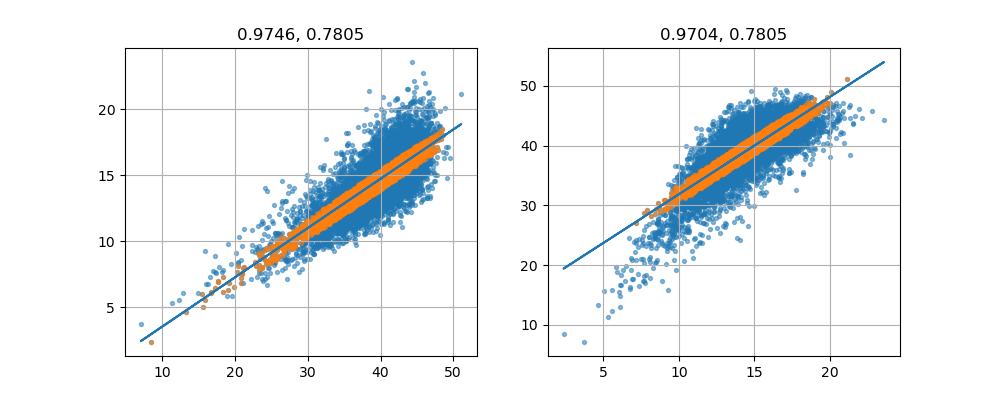

In [17]:
fig, axs = plt.subplots(1,2, figsize=(10,4))
ax1 = axs[0]
ax2 = axs[1]

ax1.scatter(arrTimesAmp_scan_126, arrTimesAmp_scan_124, s=8,alpha = 0.5, label ='unfiltered')
ax1.scatter(arrTimesAmp_scan_126_126x, arrTimesAmp_scan_124_126x,s=8, alpha = 0.5, label ='filtered')
ax1.plot(arrTimesAmp_scan_126, line)

ax2.scatter(arrTimesAmp_scan_124, arrTimesAmp_scan_126, s=8,alpha = 0.5, label ='unfiltered')
ax2.scatter(arrTimesAmp_scan_124_124x, arrTimesAmp_scan_126_124x,s=8, alpha = 0.5, label ='filtered')
ax2.plot(arrTimesAmp_scan_124, line2)

print ('{} shots out of {} survived'.format(np.shape(arrTimesAmp_scan_124_filter), np.shape(arrTimesAmp_scan_124)))

ax1.set_title('{:.4f}, {:.4f}'.format(pearsonr(arrTimesAmp_scan_124_126x, arrTimesAmp_scan_126_126x)[0], pearsonr(arrTimesAmp_scan_124, arrTimesAmp_scan_126)[0]))
ax2.set_title('{:.4f}, {:.4f}'.format(pearsonr(arrTimesAmp_scan_126_124x, arrTimesAmp_scan_124_124x)[0], pearsonr(arrTimesAmp_scan_126, arrTimesAmp_scan_124)[0]))

ax1.grid()
ax2.grid()
plt.show()

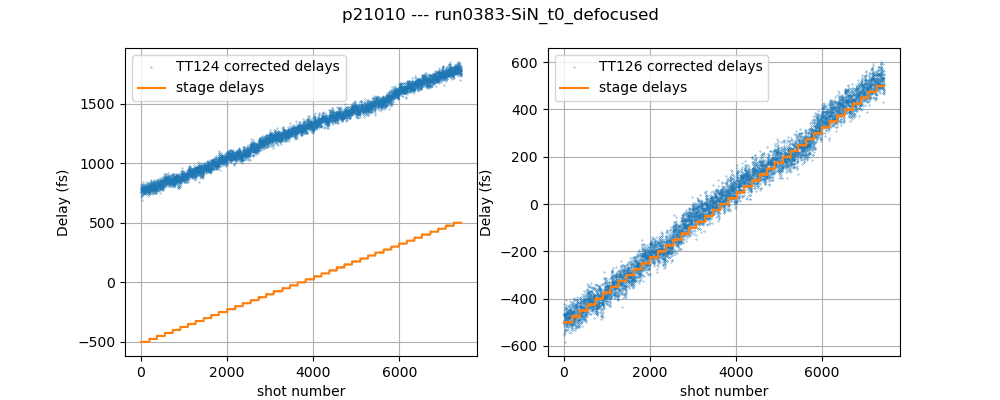

In [18]:
fig, axs = plt.subplots(1,2, figsize=(10,4))
plt.suptitle(titlestring)
ax1 = axs[0]
ax2 = axs[1]

ax1.plot(Delays_corr_scan_124, '.',ms=0.5, label = 'TT124 corrected delays')
ax1.plot(Delays_fs_scan_124, label = 'stage delays')
ax2.plot(Delays_corr_scan_126, '.',ms=0.5, label = 'TT126 corrected delays')
ax2.plot(Delays_fs_scan_126, label = 'stage delays')
ax1.legend (loc='best')
ax2.legend (loc='best')
ax1.grid()
ax2.grid()
ax1.set_xlabel('shot number')
ax1.set_ylabel('Delay (fs)')
ax2.set_xlabel('shot number')
ax2.set_ylabel('Delay (fs)')
plt.show()
plt.tight_layout()

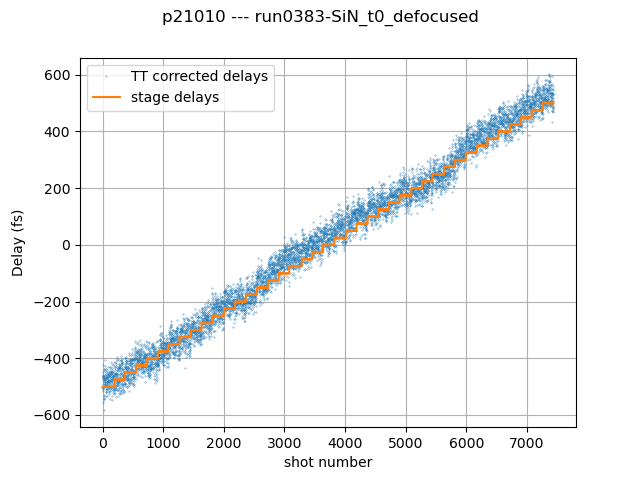

In [43]:
plt.figure()
plt.suptitle(titlestring)
plt.plot(Delays_corr_scan_126, '.',ms=0.5, label = 'TT corrected delays')
plt.plot(Delays_fs_scan_126, label = 'stage delays')

plt.xlabel('shot number')
plt.ylabel('Delay (fs)')
plt.legend (loc='best')
plt.grid()
plt.show()

## Re-bin the data with chosen binsize

In [45]:
binsize = 5 # in fs

################################################################################################3
from scipy.stats import binned_statistic
#print (np.shape(Pump_probe_scan_126_filter),np.shape(Delays_corr_scan_126_filter))
print (np.shape(Pump_probe_scan_124_filter),np.shape(Delays_corr_scan_124_filter))

Delays_corr_scan_124_filter = Delays_corr_scan_124_filter -np.mean(Delays_corr_scan_124_filter)

binList = np.arange(Delays_fs_scan_124[0] - 100, Delays_fs_scan_124[-1] + 100, binsize)
Delay_fs_TT = np.arange(Delays_fs_scan_124[0] - 100 + binsize/2, Delays_fs_scan_124[-1] + 100 - binsize/2, binsize)

pp_TT, binEdges, binNumber = binned_statistic(Delays_corr_scan_124_filter, Pump_probe_scan_124_filter, statistic='mean', bins=binList)

(10123,) (10123,)


## Choose fit function

In [46]:
# err function ---------------> [x0, amplitude, width, offset]
# exp_gauss_heaviside --------> [x0, amplitude, width, offset, lifetime]
# conv_exp_gauss_heaviside2 --> [x0, amplitude, width, offset, lifetime, a, b]

#fit = Fit(errfunc_fwhm, estimate_errfunc_parameters)
#fit = Fit(conv_exp_gauss_heaviside, estimate_conv_exp_gauss_heaviside_parameters) 
fit = Fit(conv_exp_gauss_heaviside2, estimate_conv_exp_gauss_heaviside2_parameters)

## Do the fit

In [47]:
index = ~(np.isnan(Delay_fs_TT) | np.isnan(pp_TT))
Delay_fs_TT = Delay_fs_TT[index]
pp_TT=  pp_TT[index]

fit.estimate(Delay_fs_TT, pp_TT)            # this sets some internal params 
print(fit.p0)
#fit.p0 = better_p0(fit.p0, 4, 250) # overwrite some values (index) if needed: 
#fit.p0 =[0, 0.04, 50, 0.0, 500, 3e-5, 0.035]
#fit.p0 =[0, 0.04, 50, 0.0, 500]
#print(fit.p0)
fit.p0 = better_p0(fit.p0, 4,200)
fit.fit(Delay_fs_TT,pp_TT)                  # calculate the fit
pp_fit = fit.eval(Delay_fs_TT)           # evaluate the curve for plotting

t0_fs = fit.popt[0]
t0_mm = Timezero_mm + fs2mm(t0_fs, 0)
width_fs = fit.popt[2]

print("Position t0 =",np.round(t0_mm,5),"mm")
#print("Width =",np.abs(np.round(width_mm,3))*1000,"um")
#print("Position t0 =",np.round(t0_fs,5),"fs")
print("Width =",np.abs(np.round(width_fs,5)),"fs")

(-0.2111620832209155, 0.024718969938845134, 5.0, -0.004921513416471558, 0.25, 0, 0)


RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 1600.

## Plot

ValueError: x and y must have same first dimension, but have shapes (200,) and (127,)

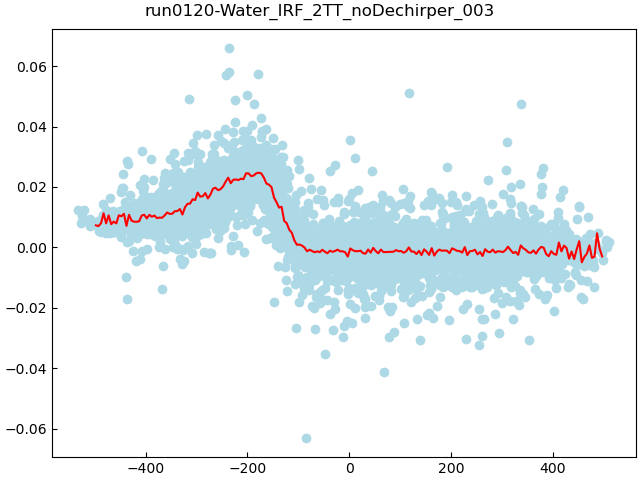

In [48]:
fig, ax = plt.subplots(constrained_layout=True)
#plt.figure(constrained_layout=True)
plt.suptitle(jsonfile.split('/')[-3] )#+ " mono")

plt.tick_params(direction='in')

plt.plot(Delays_corr_scan_124_filter, Pump_probe_scan_124_filter, 'o', color='lightblue')
# plt.plot(Delay_fs, pp_uncorrected, marker='.',label = 'raw scan, t0 = {} mm'.format(timezero_mm))
plt.plot(Delay_fs_TT, pp_TT, color='red', label = 'TT corrected')
plt.plot(Delay_fs_TT, pp_fit)

boxstyle = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
boxtext = '\n'.join((#r'Delta_t0 = {} fs'.format(np.round(t0_fs, 5)),
                     r't0_TT = {} mm'.format(np.round(Timezero_mm + fs2mm(t0_fs,0),5)),
            r'width = {} fs'.format(np.abs(np.round(width_fs, decimals = 5)))))
plt.text(0.05, 0.05, boxtext, transform=ax.transAxes, bbox=boxstyle, fontsize=14)

plt.xlabel('delay (fs)')
plt.ylabel('amplitude (arb. u.)')
plt.legend (loc = 'upper right')
#plt.ylim(-0.3, 0.3)
plt.grid()
plt.show()

print("Position t0_raw = {} mm".format(Timezero_mm ))
print("Position t0_TT = {} mm".format(Timezero_mm + fs2mm(t0_fs,0)))

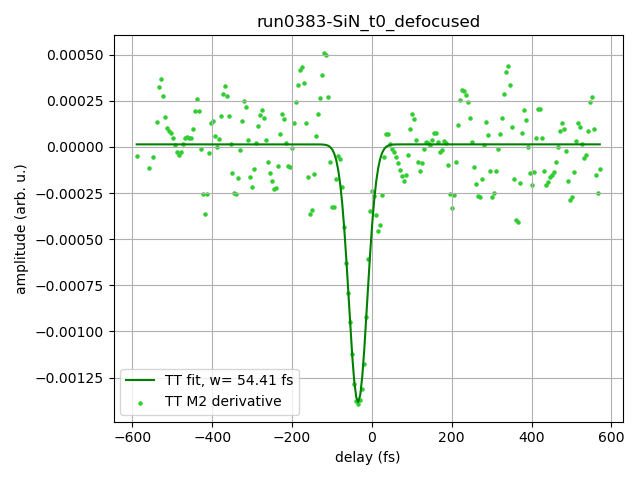

In [123]:
pp_TT_derivative = gaussian_filter1d(pp_TT, 2, order = 1)
parameters_M2,extras = curve_fit(gaussian, Delay_fs_TT, pp_TT_derivative, \
                                 p0 = [0, 0, -50, 0])

plt.figure()
plt.title(jsonfile.split('/')[-3])
plt.scatter(Delay_fs_TT, pp_TT_derivative, color='limegreen', label = 'TT M2 derivative', s = 5)
plt.plot(Delay_fs_TT, gaussian(Delay_fs_TT,*parameters_M2), color='green',\
         label = 'TT fit, w= {:.2f} fs'.format(np.abs(parameters_M2[2]*2.355)))

plt.legend(loc='lower left')

plt.xlabel('delay (fs)')
plt.ylabel('amplitude (arb. u.)')
plt.grid()
plt.tight_layout()
plt.show()


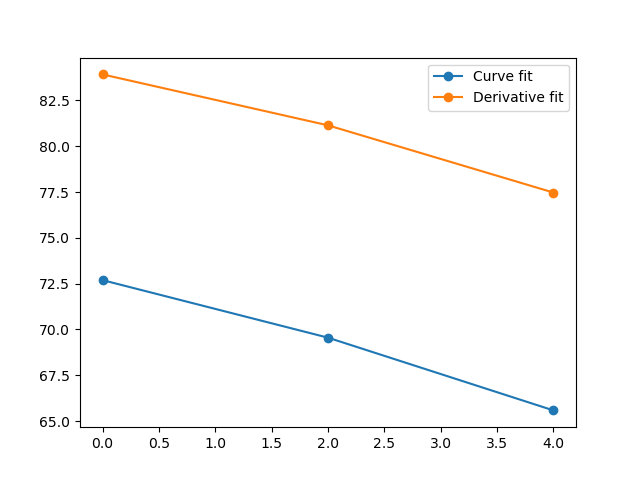

In [213]:
compressor_steps = [0, 2, 4]
width = [72.69, 69.55, 65.58]
width_der = [83.92, 81.14, 77.47]

plt.figure()
plt.plot(compressor_steps, width, marker = 'o', label = 'Curve fit')
plt.plot(compressor_steps, width_der, marker = 'o', label = 'Derivative fit')
plt.legend()
plt.show()

# Loop over several runs

In [13]:
datafiles = []
#for file in glob.glob('/gpfs/photonics/swissfel/raw/alvra-staff/p19776/run*YAG_pink_air_loop*/meta/scan.json'):
for file in glob.glob('/sf/alvra/data/p19776/raw/run*YAG_pink_air_loop*/meta/scan.json'):
    datafiles.append(file)
datafiles = sorted(datafiles, key = os.path.getmtime)
patch =  datafiles[:5]
patch

['/sf/alvra/data/p19776/raw/run0438-YAG_pink_air_loop_001/meta/scan.json',
 '/sf/alvra/data/p19776/raw/run0439-YAG_pink_air_loop_002/meta/scan.json',
 '/sf/alvra/data/p19776/raw/run0440-YAG_pink_air_loop_003/meta/scan.json',
 '/sf/alvra/data/p19776/raw/run0441-YAG_pink_air_loop_004/meta/scan.json',
 '/sf/alvra/data/p19776/raw/run0442-YAG_pink_air_loop_005/meta/scan.json']

In [14]:
TT = TT_PSEN126

quantile_band = 0.5
binsize = 10 # in fs

channel_delay_motor = channel_delay_topas

Timezero_mm = 108.72812 

flag = False

#target = 'babyYAG'
#px2fs = 1.8692375 ## calibration from 17.10.2021

########################################################################
from sfdata import SFScanInfo
from scipy.stats import binned_statistic

t0_fs_scan =[]
width_fs_scan = []
width_fs_scan_der = []

timestamps_npy = []
timestamps_hms = []

for num, json_file in enumerate(patch):
    scan = SFScanInfo(json_file)
    scan = remove_JF_from_scan(scan)
    
    try:
        Timezero_mm = get_timezero_NBS(json_file)
        flag = True
    except:
        Timezero_mm = Timezero_mm
    
    Delay_fs, Delays_corr, Pump_probe, Pump_probe_scan = \
    YAG_scan_one_TT_bs(scan, TT, channel_delay_motor, Timezero_mm, quantile_band)

    print (np.shape(Pump_probe_scan),np.shape(Delays_corr))

    binList = np.arange(Delay_fs[0] - 100, Delay_fs[-1] + 100, binsize)
    Delay_fs_TT = np.arange(Delay_fs[0] -100 + binsize/2, Delay_fs[-1] + 100 - binsize/2, binsize)

    pp_TT, binEdges, binNumber = binned_statistic(Delays_corr, Pump_probe_scan, statistic='mean', bins=binList)
    
    fit = Fit(errfunc_fwhm, estimate_errfunc_parameters)
    # fit = Fit(conv_exp_gauss_heaviside, estimate_conv_exp_gauss_heaviside_parameters) 
    # fit = Fit(conv_exp_gauss_heaviside2, estimate_conv_exp_gauss_heaviside2_parameters)
    
    index = ~(np.isnan(Delay_fs_TT) | np.isnan(pp_TT))
    Delay_fs_TT = Delay_fs_TT[index]
    pp_TT=  pp_TT[index]

    fit.estimate(Delay_fs_TT, pp_TT)            # this sets some internal params 

    #fit.p0 = better_p0(fit.p0, 0, 210.42) # overwrite some values (index) if needed:
    #fit.p0 =[191.06, 0.04, 80, 0.0, 500]#, 3e-5, 0.035]

    fit.fit(Delay_fs_TT,pp_TT)                  # calculate the fit
    pp_fit = fit.eval(Delay_fs_TT)           # evaluate the curve for plotting
    
    t0_fs = fit.popt[0]
    width_fs = fit.popt[2]
    
    pp_TT_derivative = gaussian_filter1d(pp_TT, 2, order = 1)
    parameters_der,extras = curve_fit(gaussian, Delay_fs_TT, pp_TT_derivative, \
                                 p0 = [0, 0,-50, 0])
    
    t0_fs_scan.append(t0_fs)
    width_fs_scan.append(width_fs)
    width_fs_scan_der.append(np.abs(parameters_der[2]*2.355))
    
    #ax.scatter(Delay_fs_TT, pp_TT_derivative, color=colors[num], s = 5)
    #ax.plot(Delay_fs_TT, gaussian(Delay_fs_TT,*parameters_der), color=colors[num],\
    #        label = '{:.2f} fs'.format(np.abs(parameters_der[2]*2.355)))
    
    timestamps_npy.append(timestamp(json_file))
    timestamps_hms.append(timestamp_hms(json_file))

    print ('------------------------------')
    if flag:
        print ('Timezero found in file = {} mm'.format(Timezero_mm))
    else:
        print ('Timezero = {} mm'.format(Timezero_mm))


Processing: run0442-YAG_pink_air_loop_005
Step 81 of 81: Processing acq0081

--------------------------------------------------------------------------------

SAR-CVME-TIFALL5:EvtSet                  251 / 251 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SARES11-SPEC125-M1.edge_amplitude        251 / 251 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SARES11-SPEC125-M1.edge_derivative       251 / 251 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SARES11-SPEC125-M1.edge_position         251 / 251 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SARES11-SPEC125-M1.edge_raw              251 / 251 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SARES11-SPEC125-M1.projection_background 251 / 251 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SARES11-SPEC125-M1.projection_signal     251 / 251 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SLAAR11-LMOT-M451:ENC_1_BS               251 / 251 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SLAAR11-LSCP1-FNS:CH0:VAL_GET            251 / 251 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SLAAR11-LSCP1-FNS:CH2:VAL_GET            251 / 251 -> 0% loss ▇▇▇▇▇▇▇▇▇▇

over the whole data set: 251 / 251 -> 0% loss
complete channels: 10 / 10 -> 0% incomplete

-------------------

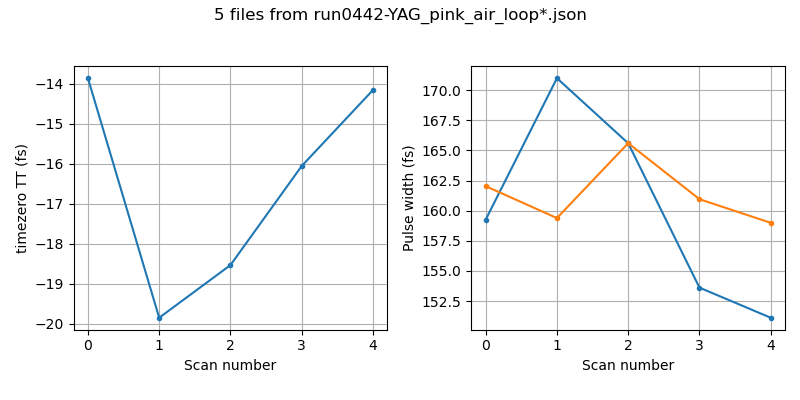

In [15]:
#scan_number = np.delete(np.array(range(123)), [0,65,109,110])

#t0_fs_scan_clean = np.delete(t0_fs_scan[:121], [107,108])
#width_fs_scan_clean = np.delete(width_fs_scan[:121], [107,108])

plt.figure(figsize = (8,4))
#plt.suptitle ('{} files from {}'.format(len(patch), json_file.split('/')[-3].split('.')[0][:-4]+'*.json'))
plt.suptitle ('{} files from {}'.format(len(patch), json_file.split('/')[-3].split('.')[0][:-4]+'*.json'))


plt.subplot(121)
plt.plot(t0_fs_scan, marker='.')
plt.xlabel("Scan number")
plt.ylabel('timezero TT (fs)')
plt.grid()

plt.subplot(122)
plt.plot(width_fs_scan, marker='.', label = 'Convolution fit')
plt.plot(width_fs_scan_der, marker='.', label = 'Derivative fit')

plt.xlabel('Scan number')
plt.ylabel('Pulse width (fs)')
plt.grid()

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

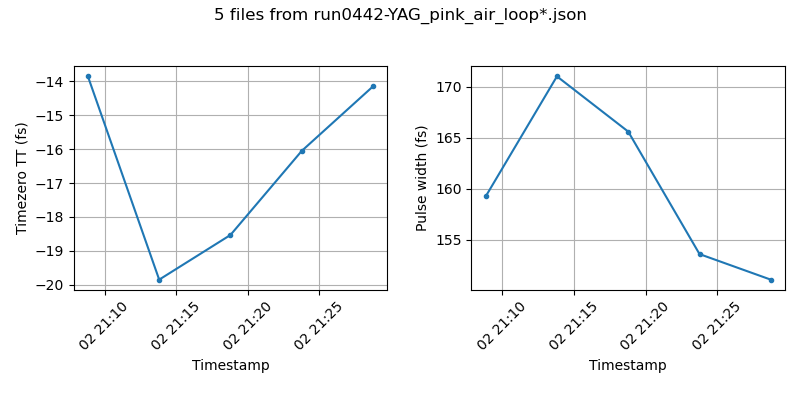

In [16]:
#scan_number = np.delete(np.array(range(123)), [0,65,109,110])

#t0_fs_scan_clean = np.delete(t0_fs_scan[:121], [107,108])
#width_fs_scan_clean = np.delete(width_fs_scan[:121], [107,108])

plt.figure(figsize = (8,4))
plt.suptitle ('{} files from {}'.format(len(patch), json_file.split('/')[-3].split('.')[0][:-4]+'*.json'))
# plt.suptitle ('{} files from {}'.format(79+46, json_file.split('/')[-3].split('.')[0][:-4]+'*.json'))

plt.subplot(121)
plt.plot(timestamps_npy, t0_fs_scan, marker='.')
plt.xlabel("Timestamp")
plt.ylabel('Timezero TT (fs)')
plt.xticks(rotation = 45)
plt.grid()

plt.subplot(122)
plt.plot(timestamps_npy, width_fs_scan, marker='.')
plt.xlabel('Timestamp')
plt.ylabel('Pulse width (fs)')
plt.xticks(rotation = 45)
plt.grid()

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

##  Timing tool traces & statistics

In [2]:
fc = FileChooser('/sf/alvra/data/p19776/raw/')
fc.use_dir_icons = True
display(fc)

FileChooser(path='/sf/alvra/data/p19776/raw', filename='', title='HTML(value='', layout=Layout(display='none')…

In [3]:
TT = TT_PSEN126

target = 'babyYAG'
px2fs = 1.8692375 

arrTimes, arrTimesAmp, arrTimes_scan, arrTimesAmp_scan, peaktraces = \
TT_statistics_scan(fc.selected, TT, target, px2fs)

Processing: run0154
Step 61 of 61: Processing acq0061

--------------------------------------------------------------------------------

SAR-CVME-TIFALL4:EvtSet                 501 / 501 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SARES11-SPEC125-M1.roi_signal_x_profile 501 / 501 -> 0% loss ▇▇▇▇▇▇▇▇▇▇

over the whole data set: 501 / 501 -> 0% loss
complete channels: 2 / 2 -> 0% incomplete

--------------------------------------------------------------------------------

Probe rep rate (FEL) is 100.0 Hz
Pump scheme is 1:1
Loaded 250 pump and 250 unpump shots
Sig SARES11-SPEC125-M1.roi_signal_x_profile=(250, 2048)
Sig SARES11-SPEC125-M1.roi_signal_x_profile=(250, 2048)


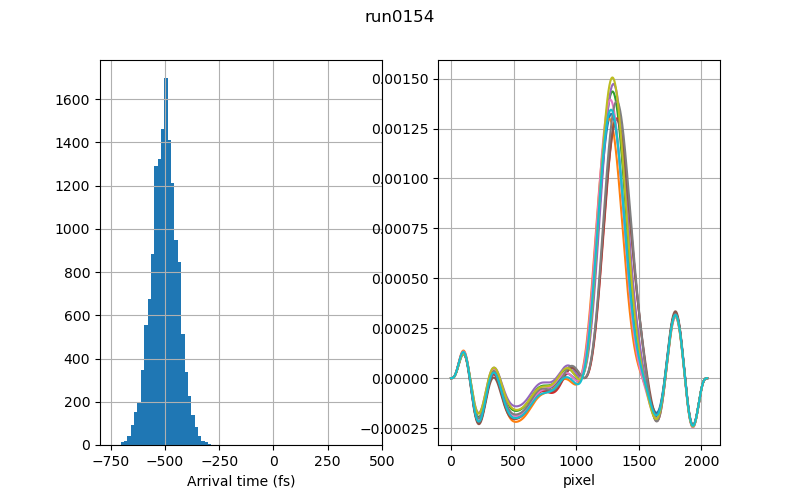

Statistics on all (14543,) shots of the scan
Offset compared to pixel 1024 is -502.3513764672008 fs
Jitter, i.e. width (std) of the histogram 59.857580568151434 fs
--------------------------------------------------------------
Statistics on (250,) shots of the last step of the scan
Offset compared to pixel 1024 is -504.67169415 fs
Jitter, i.e. width (std) of the histogram 44.93531310824471 fs


In [7]:
plt.figure(figsize = (8,5))
plt.subplot(121)
plt.hist(arrTimes_scan, bins=30)
plt.grid()
plt.xlim(-800,500)
plt.xlabel('Arrival time (fs)')

plt.subplot(122)
plt.suptitle (fc.selected.split('/')[-3])
for i in range(10):
   # plt.plot(sigtraces[i][200:1500])
    #plt.plot(pixelNum[100:2047], sigtraces[i][0:1947])
    plt.plot(peaktraces[i])#*10000)
plt.xlabel ('pixel')
#plt.xlim(500,1500)
plt.grid()
plt.show()

print("Statistics on all {} shots of the scan".format(np.shape(arrTimes_scan)))
print("Offset compared to pixel 1024 is {} fs".format(np.mean(arrTimes_scan)))
print("Jitter, i.e. width (std) of the histogram {} fs".format(np.std(arrTimes_scan)))
print("--------------------------------------------------------------")
print("Statistics on {} shots of the last step of the scan".format(np.shape(arrTimes)))
print("Offset compared to pixel 1024 is {} fs".format(np.mean(arrTimes)))
print("Jitter, i.e. width (std) of the histogram {} fs".format(np.std(arrTimes)))
